In [115]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit
from algo.utils import process_hamiltonian_Zs

from qiskit_algorithms import NumPyMinimumEigensolver
from algo.oicd import oicd
from algo.utils import (
    expectation_loss_grad,
    interp_matrix,
    optimal_interp_points,
    mse
)

In [116]:
import matplotlib

# Update matplotlib settings with specified fonts and sizes
fontsize = 20
# 全局设置 dpi 和 bbox_inches
matplotlib.rcParams.update({
    'savefig.dpi': 400,  # 设置保存图像时的 DPI
    'savefig.bbox': 'tight',  # 设置保存时去除空白区域
    'font.family': 'serif',
    'axes.labelsize': fontsize,
    'font.size': fontsize,
    'legend.fontsize': 12,
    'axes.titlesize': 20,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'lines.linewidth': 3,
    # 'text.usetex': True,
})
# Define custom color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [117]:
ham_str = '0.5 - 3 * z0  + 0.5 * z1 * z0 + 0.5 * z2 * z0 + 0.5 * z2 * z1 + 0.5 * z3 * z0 + 0.5 * z3 * z2'

# global
num_q = 4  # Number of qubits
layer = 5
num_p = layer * num_q

In [118]:
max_stars = 2  # Maximum number of stars to categorize terms (e.g., 0-star, 1-star, 2-star, 3-star)
# Call the function to process the Hamiltonian string
all_lists, all_coeffs = process_hamiltonian_Zs(ham_str, num_q, max_stars)

# Output the results for each star category
for i, (term_positions, term_coeffs) in enumerate(zip(all_lists, all_coeffs)):
    print(f"Terms with {i} star(s):")
    print("Coefficients:", term_coeffs)
    print("Positions:", term_positions)

print('')

List_0, List_1, List_2 = all_lists
List = List_0 + List_1 + List_2

coeff_0, coeff_1, coeff_2 = all_coeffs
coeff = coeff_0 + coeff_1 + coeff_2

H = SparsePauliOp(List, coeff)
print(H)

Terms with 0 star(s):
Coefficients: [0.5]
Positions: ['IIII']
Terms with 1 star(s):
Coefficients: [-3.0]
Positions: ['ZIII']
Terms with 2 star(s):
Coefficients: [0.5, 0.5, 0.5, 0.5, 0.5]
Positions: ['ZZII', 'ZIZI', 'IZZI', 'ZIIZ', 'IIZZ']

SparsePauliOp(['IIII', 'ZIII', 'ZZII', 'ZIZI', 'IZZI', 'ZIIZ', 'IIZZ'],
              coeffs=[ 0.5+0.j, -3. +0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j])


In [119]:
# Directly use NumPyMinimumEigensolver
eigensolver = NumPyMinimumEigensolver()
result = eigensolver.compute_minimum_eigenvalue(operator=H)

# Extract the ground state energy and ground state vector
ground_energy = result.eigenvalue.real
# ground_state = result.eigenstate  # This is a statevector

print(f"Ground state energy = {ground_energy}")
# print(f"Ground state vector = {ground_state}")


Ground state energy = -3.9999999999999973


In [120]:
def circuit_HEA(num_q: int, layer: int):

    num_p = num_q * layer
    theta = ParameterVector("θ", num_p)
    
    circ = QuantumCircuit(num_q)
    
    for i in range(layer):  # Iterate over each layer
        for j in range(num_q): 
            circ.ry(theta[num_q*i+j], j)  # Apply RY gate to each qubit, the angle is given by elements in the weights array
        for j in range(num_q-1):  
            circ.cz(j, j+1) # Apply CZ gate to each pair of adjacent qubits
    
    return circ, theta

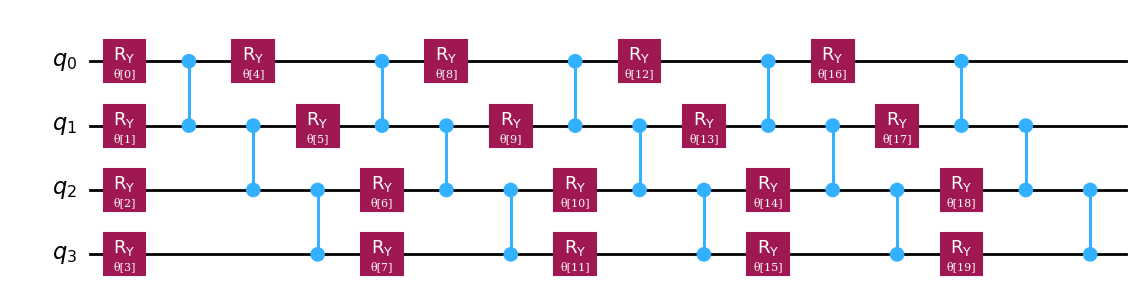

In [121]:
qc, _ = circuit_HEA(num_q, layer)
# print(qc)
qc.draw("mpl")

In [122]:

def expectation_loss(weights):
    return expectation_loss_grad(num_q,
                                 layer,
                                 weights,
                                 circuit=circuit_HEA,
                                 obs=H,
                                 )


def estimate_loss(weights, shots):
    return expectation_loss_grad(num_q,
                                 layer,
                                 weights,
                                 circuit=circuit_HEA,
                                 obs=H,
                                 shots=shots)
                                 

In [123]:
tol=1e-2
plot_flag=True
initial_weights = np.random.uniform(0, 2*np.pi, size=num_p)
n_shot=1024
print(f"Ground state energy: {ground_energy}")

Ground state energy: -3.9999999999999973


In [124]:
# Initialization
omegas = [1]
num_iter = 250  # Number of iterations for optimization
r=2 * len(omegas) + 1

# true data (k-nodes)

In [125]:
k_set = [0.5, 1, 1.5, 2]
interp_configs = [np.linspace(0, k * np.pi, r, endpoint=False) for k in k_set]
MSE_values = [mse(nodes, omegas) for nodes in interp_configs]

weights_dict = {}
all_metrics = []

# Loop over the different `interp_nodes` configurations
for interp_nodes in interp_configs:
    inverse_interp_matrix = np.linalg.inv(interp_matrix(interp_nodes, omegas))
    
    # Update the weights_dict with the current configuration
    for i in range(num_p):
        weights_dict[f'weights_{i}'] = {
            'omegas': omegas,
            'scale_factor': 1.0,
            'interp_nodes': interp_nodes,
            'inverse_interp_matrix': inverse_interp_matrix,
        }

    # Run OICD optimization
    _, _, best_expected_record_value_oicd, func_oicd, _, metric_oicd = oicd(
        estimate_loss,
        expectation_loss,
        ground_energy,
        n_shot, weights_dict, initial_weights, num_iter,
        cyclic_mode=True, # !!!!!!!!!!!
        use_pratical_interp_flag=False, # !!!!!!!!!!!
        use_local_solvers_flag=False,
        use_global_solvers_flag = False,
        use_eigen_method_flag = True,
        use_exact_update_frequencey_1_flag = False,
        exact_mode=True, # !!!!!!!!!!!
        plot_flag=False,
        plot_argmin_flag=False,
        tol = tol,
        refresh_print_bar=True
    )

    all_metrics.append(metric_oicd)


----------------------------------------------------------------------------------------------------


Bar desc:   0%|          | 0/250 [00:00<?, ?it/s]

[OICD] Iter: 54, 14(20), Metric: 0.0099, Elapsed: 0.02s:  22%|██▏       | 54/250 [00:01<00:04, 48.78it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 54, 14(20), Metric: 0.0099, Elapsed: 0.02s:  22%|██▏       | 54/250 [00:01<00:03, 49.04it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 54, 14(20), Metric: 0.0099, Elapsed: 0.02s:  22%|██▏       | 54/250 [00:01<00:04, 48.71it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 54, 14(20), Metric: 0.0099, Elapsed: 0.02s:  22%|██▏       | 54/250 [00:01<00:04, 48.97it/s]


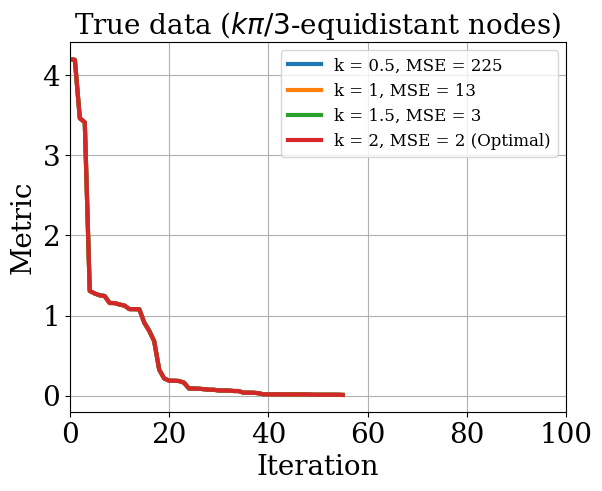

In [126]:
# Plot the results
plt.figure()

# Loop through and plot the best_expected_record_value_oicd for each configuration
for idx, values in enumerate(all_metrics):
    label=f'k = {k_set[idx]}, MSE = {MSE_values[idx]:.0f}'
    if idx == len(all_metrics) - 1:
        label=f'k = {k_set[idx]}, MSE = {MSE_values[idx]:.0f} (Optimal)'
    plt.plot(values, label=label)

# Customize the plot
plt.xlabel("Iteration")
plt.ylabel("Metric")
plt.xlim(0, 100)
plt.title("True data ($k\\pi/3$-equidistant nodes)")
plt.legend()
plt.grid(True)
plt.savefig('True-Data-Fixed-k-Nodes.png')
plt.show()

# true data (random nodes)

In [127]:
interp_configs = [np.random.uniform(0, 2*np.pi, r) for _ in range(4)] 
MSE_values = [mse(nodes, omegas) for nodes in interp_configs]

weights_dict = {}
all_metrics = []

# Loop over the different `interp_nodes` configurations
for interp_nodes in interp_configs:
    inverse_interp_matrix = np.linalg.inv(interp_matrix(interp_nodes, omegas))
    
    # Update the weights_dict with the current configuration
    for i in range(num_p):
        weights_dict[f'weights_{i}'] = {
            'omegas': omegas,
            'scale_factor': 1.0,
            'interp_nodes': interp_nodes,
            'inverse_interp_matrix': inverse_interp_matrix,
        }

    # Run OICD optimization
    _, _, best_expected_record_value_oicd, func_oicd, _, metric_oicd = oicd(
        estimate_loss,
        expectation_loss,
        ground_energy,
        n_shot, weights_dict, initial_weights, num_iter,
        cyclic_mode=True, # !!!!!!!!!!!
        use_pratical_interp_flag=False, # !!!!!!!!!!!
        use_local_solvers_flag=False,
        use_global_solvers_flag = False,
        use_eigen_method_flag = True,
        use_exact_update_frequencey_1_flag = False,
        exact_mode=True, # !!!!!!!!!!!
        plot_flag=False,
        plot_argmin_flag=False,
        tol = tol,
        refresh_print_bar=True
    )

    all_metrics.append(metric_oicd)


----------------------------------------------------------------------------------------------------


[OICD] Iter: 20, 0(20), Metric: 0.1868, Elapsed: 0.02s:   8%|▊         | 21/250 [00:00<00:04, 48.34it/s] 


KeyboardInterrupt: 

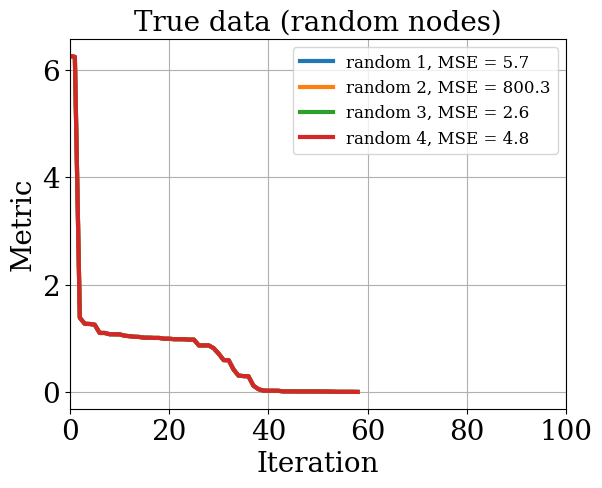

In [ ]:
# Plot the results
plt.figure()

# Loop through and plot the best_expected_record_value_oicd for each configuration
for idx, values in enumerate(all_metrics):
    label=f'random {idx+1}, MSE = {MSE_values[idx]:.1f}'
    plt.plot(values, label=label)

# Customize the plot
plt.xlabel("Iteration")
plt.ylabel("Metric")
plt.xlim(0, 100)
plt.title("True data (random nodes)")
plt.legend()
plt.grid(True)
plt.savefig('True-Data-Random-Nodes.png')
plt.show()

# nosiy data + pratical algo (k-nodes)

In [128]:
k_set = [0.5, 1, 1.5, 2]
interp_configs = [np.linspace(0, k * np.pi, r, endpoint=False) for k in k_set]
MSE_values = [mse(nodes, omegas) for nodes in interp_configs]

weights_dict = {}
all_metrics = []

# Loop over the different `interp_nodes` configurations
for interp_nodes in interp_configs:
    inverse_interp_matrix = np.linalg.inv(interp_matrix(interp_nodes, omegas))
    
    # Update the weights_dict with the current configuration
    for i in range(num_p):
        weights_dict[f'weights_{i}'] = {
            'omegas': omegas,
            'scale_factor': 1.0,
            'interp_nodes': interp_nodes,
            'inverse_interp_matrix': inverse_interp_matrix,
        }

    # Run OICD optimization
    _, _, best_expected_record_value_oicd, func_oicd, _, metric_oicd = oicd(
        estimate_loss,
        expectation_loss,
        ground_energy,
        n_shot, weights_dict, initial_weights, num_iter,
        cyclic_mode=True, # !!!!!!!!!!!
        use_pratical_interp_flag=True, # !!!!!!!!!!!!!!
        use_local_solvers_flag=False,
        use_global_solvers_flag = False,
        use_eigen_method_flag = True,
        use_exact_update_frequencey_1_flag = False,
        exact_mode=False, # !!!!!!!!!!!!!!
        plot_flag=False,
        plot_argmin_flag=False,
        tol = tol,
        refresh_print_bar=True
    )

    all_metrics.append(metric_oicd)


----------------------------------------------------------------------------------------------------


[OICD] Iter: 249, 9(20), Metric: 5.6797, Elapsed: 0.02s: 100%|██████████| 250/250 [00:04<00:00, 55.44it/s] 


----------------------------------------------------------------------------------------------------


[OICD] Iter: 249, 9(20), Metric: 2.7000, Elapsed: 0.02s: 100%|██████████| 250/250 [00:04<00:00, 53.66it/s] 


----------------------------------------------------------------------------------------------------


[OICD] Iter: 249, 9(20), Metric: 1.9767, Elapsed: 0.02s: 100%|██████████| 250/250 [00:04<00:00, 56.34it/s] 


----------------------------------------------------------------------------------------------------


[OICD] Iter: 121, 1(20), Metric: 0.0075, Elapsed: 0.02s:  48%|████▊     | 121/250 [00:02<00:02, 54.40it/s] 


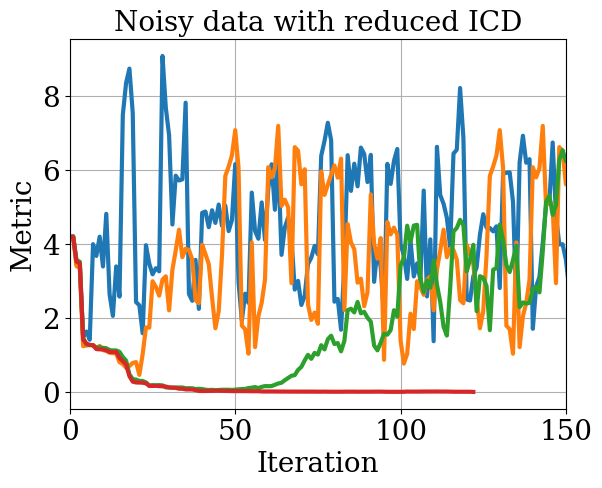

In [129]:
# Plot the results
plt.figure()

# Loop through and plot the best_expected_record_value_oicd for each configuration
for idx, values in enumerate(all_metrics):
    label=f'k = {k_set[idx]}, MSE = {MSE_values[idx]:.0f}'
    if idx == len(all_metrics) - 1:
        label=f'k = {k_set[idx]}, MSE = {MSE_values[idx]:.0f} (Optimal)'
    plt.plot(values, label=label)

# Customize the plot
plt.xlabel("Iteration")
plt.ylabel("Metric")
plt.xlim(0, 150)
# plt.title("Run OICD with Noisy data and pratical algo")
plt.title("Noisy data with reduced ICD")
# plt.legend()
plt.grid(True)
plt.savefig('Noisy-Data-Practical-ICD.png')
plt.show()

# nosiy data + vanila algo (k-nodes)

In [130]:
n_shot = 1024
num_iter = 300

In [131]:
k_set = [0.5, 1, 1.5, 2]
interp_configs = [np.linspace(0, k * np.pi, r, endpoint=False) for k in k_set]
MSE_values = [mse(nodes, omegas) for nodes in interp_configs]

weights_dict = {}
all_metrics = []

# Loop over the different `interp_nodes` configurations
for interp_nodes in interp_configs:
    inverse_interp_matrix = np.linalg.inv(interp_matrix(interp_nodes, omegas))
    
    # Update the weights_dict with the current configuration
    for i in range(num_p):
        weights_dict[f'weights_{i}'] = {
            'omegas': omegas,
            'scale_factor': 1.0,
            'interp_nodes': interp_nodes,
            'inverse_interp_matrix': inverse_interp_matrix,
        }

    # Run OICD optimization
    _, _, best_expected_record_value_oicd, func_oicd, _, metric_oicd = oicd(
        estimate_loss,
        expectation_loss,
        ground_energy,
        n_shot, weights_dict, initial_weights, num_iter,
        cyclic_mode=True, # !!!!!!!!!!!
        use_pratical_interp_flag=False, # !!!!!!!!!!!
        use_local_solvers_flag=False,
        use_global_solvers_flag = False,
        use_eigen_method_flag = True,
        use_exact_update_frequencey_1_flag = False,
        exact_mode=False,  # !!!!!!!!!!!
        plot_flag=False,
        plot_argmin_flag=False,
        tol = tol,
        refresh_print_bar=True
    )

    all_metrics.append(metric_oicd)


----------------------------------------------------------------------------------------------------


[OICD] Iter: 0, 0(20), Metric: 4.2371, Elapsed: 0.02s:   0%|          | 0/300 [00:00<?, ?it/s]

[OICD] Iter: 299, 19(20), Metric: 0.0356, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.18it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 69, 9(20), Metric: 0.0093, Elapsed: 0.02s:  23%|██▎       | 69/300 [00:01<00:05, 44.64it/s] 


----------------------------------------------------------------------------------------------------


[OICD] Iter: 83, 3(20), Metric: 0.0070, Elapsed: 0.02s:  28%|██▊       | 83/300 [00:01<00:04, 44.73it/s] 


----------------------------------------------------------------------------------------------------


[OICD] Iter: 58, 18(20), Metric: 0.0077, Elapsed: 0.02s:  19%|█▉        | 58/300 [00:01<00:05, 44.89it/s]


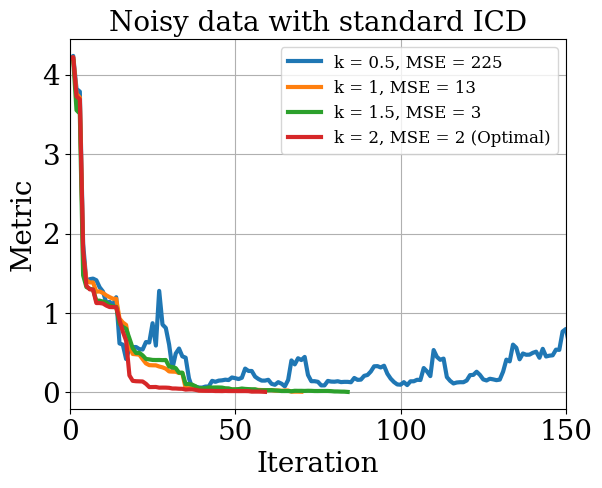

In [132]:
# Plot the results
plt.figure()

# Loop through and plot the best_expected_record_value_oicd for each configuration
for idx, values in enumerate(all_metrics):
    label=f'k = {k_set[idx]}, MSE = {MSE_values[idx]:.0f}'
    if idx == len(all_metrics) - 1:
        label=f'k = {k_set[idx]}, MSE = {MSE_values[idx]:.0f} (Optimal)'
    plt.plot(values, label=label)

# Customize the plot
plt.xlabel("Iteration")
plt.ylabel("Metric")
plt.xlim(0, 150)
plt.title("Noisy data with standard ICD")
plt.legend()
plt.grid(True)
plt.savefig('Noisy-Data-Vanilla-ICD.png')
plt.show()

# nosiy data + vanila algo (k-nodes) (varying shot)


In [133]:
def run_oicd_all_shots(num_p, ground_energy, initial_weights, omegas, num_iter, k_set, shot_list, tol):
    r = 2 * len(omegas) + 1
    interp_configs = [np.linspace(0, k * np.pi, r, endpoint=False) for k in k_set]
    MSE_values = [mse(nodes, omegas) for nodes in interp_configs]

    all_results = []

    for current_shot in shot_list:
        print(f"\n===== Running for n_shot = {current_shot} =====")
        metrics_per_k = []

        for interp_nodes in interp_configs:
            inverse_interp_matrix = np.linalg.inv(interp_matrix(interp_nodes, omegas))
            weights_dict = {
                f'weights_{i}': {
                    'omegas': omegas,
                    'scale_factor': 1.0,
                    'interp_nodes': interp_nodes,
                    'inverse_interp_matrix': inverse_interp_matrix,
                }
                for i in range(num_p)
            }

            _, _, _, _, _, metric_oicd = oicd(
                estimate_loss,
                expectation_loss,
                ground_energy,
                current_shot,
                weights_dict,
                initial_weights,
                num_iter,
                cyclic_mode=True, # !!!!!!!!!!!
                use_pratical_interp_flag=False, # !!!!!!!!!!!
                use_local_solvers_flag=False,
                use_global_solvers_flag=False,
                use_eigen_method_flag=True,
                use_exact_update_frequencey_1_flag=False,
                exact_mode=False, # !!!!!!!!!!!
                plot_flag=False,
                plot_argmin_flag=False,
                tol=tol,
                refresh_print_bar=True
            )

            metrics_per_k.append(metric_oicd)

        all_results.append({
            'n_shot': current_shot,
            'metrics': metrics_per_k
        })

    return all_results, interp_configs, MSE_values


In [134]:
tol = 1e-2
omegas = [1]
num_iter = 300
k_set_1 = [0.5, 1, 1.5, 2]
shot_list_1 = [2**n for n in reversed(range(1, 13))] # from 4096 to 2

# Step 1: 生成数据
all_results_1, interp_configs, MSE_values = run_oicd_all_shots(
    num_p, ground_energy, initial_weights, omegas,
    num_iter, k_set_1, shot_list_1, tol
)



===== Running for n_shot = 4096 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 247, 7(20), Metric: 0.0099, Elapsed: 0.02s:  82%|████████▏ | 247/300 [00:05<00:01, 45.52it/s] 


----------------------------------------------------------------------------------------------------


[OICD] Iter: 35, 15(20), Metric: 0.0077, Elapsed: 0.02s:  12%|█▏        | 35/300 [00:00<00:06, 42.84it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 26, 6(20), Metric: 0.0077, Elapsed: 0.02s:   9%|▊         | 26/300 [00:00<00:06, 42.64it/s] 


----------------------------------------------------------------------------------------------------


[OICD] Iter: 35, 15(20), Metric: 0.0099, Elapsed: 0.02s:  12%|█▏        | 35/300 [00:00<00:06, 43.61it/s]



===== Running for n_shot = 2048 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 214, 14(20), Metric: 0.0043, Elapsed: 0.02s:  71%|███████▏  | 214/300 [00:04<00:01, 44.53it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 52, 12(20), Metric: 0.0080, Elapsed: 0.02s:  17%|█▋        | 52/300 [00:01<00:05, 44.59it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 76, 16(20), Metric: 0.0096, Elapsed: 0.02s:  25%|██▌       | 76/300 [00:01<00:05, 44.51it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 59, 19(20), Metric: 0.0096, Elapsed: 0.02s:  20%|█▉        | 59/300 [00:01<00:05, 44.38it/s]



===== Running for n_shot = 1024 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 0.4006, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 43.86it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 55, 15(20), Metric: 0.0087, Elapsed: 0.02s:  18%|█▊        | 55/300 [00:01<00:05, 44.76it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 62, 2(20), Metric: 0.0100, Elapsed: 0.02s:  21%|██        | 62/300 [00:01<00:05, 44.88it/s] 


----------------------------------------------------------------------------------------------------


[OICD] Iter: 97, 17(20), Metric: 0.0091, Elapsed: 0.02s:  32%|███▏      | 97/300 [00:02<00:04, 45.09it/s]



===== Running for n_shot = 512 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 0.1211, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.40it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 236, 16(20), Metric: 0.0093, Elapsed: 0.02s:  79%|███████▊  | 236/300 [00:05<00:01, 43.73it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 78, 18(20), Metric: 0.0060, Elapsed: 0.02s:  26%|██▌       | 78/300 [00:01<00:04, 44.41it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 49, 9(20), Metric: 0.0099, Elapsed: 0.02s:  16%|█▋        | 49/300 [00:01<00:05, 44.42it/s] 



===== Running for n_shot = 256 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 1.1192, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.41it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 0.4103, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.05it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 71, 11(20), Metric: 0.0094, Elapsed: 0.02s:  24%|██▎       | 71/300 [00:01<00:05, 44.84it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 158, 18(20), Metric: 0.0094, Elapsed: 0.02s:  53%|█████▎    | 158/300 [00:03<00:03, 43.49it/s]



===== Running for n_shot = 128 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 2.7372, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.17it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 0.2347, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.20it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 121, 1(20), Metric: 0.0077, Elapsed: 0.02s:  40%|████      | 121/300 [00:02<00:04, 44.48it/s] 


----------------------------------------------------------------------------------------------------


[OICD] Iter: 75, 15(20), Metric: 0.0075, Elapsed: 0.02s:  25%|██▌       | 75/300 [00:01<00:05, 40.29it/s]



===== Running for n_shot = 64 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 3.6904, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 44.60it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 0.8579, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 43.74it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 0.1679, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 43.47it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 0.0185, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.43it/s]



===== Running for n_shot = 32 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 2.6138, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.67it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 1.4325, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 44.29it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 0.4329, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.38it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 131, 11(20), Metric: 0.0090, Elapsed: 0.02s:  44%|████▎     | 131/300 [00:02<00:03, 44.43it/s]



===== Running for n_shot = 16 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 3.8832, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.46it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 1.3627, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 44.16it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 0.9027, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.72it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 0.4711, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.29it/s]



===== Running for n_shot = 8 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 4.4529, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 44.62it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 1.1553, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.81it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 2.2208, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.84it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 2.0421, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 44.30it/s]



===== Running for n_shot = 4 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 3.5373, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.17it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 2.2069, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 45.27it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 3.4935, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 43.98it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 1.5580, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 44.82it/s]



===== Running for n_shot = 2 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 4.0126, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 44.21it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 1.8579, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 44.23it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 1.7620, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 44.96it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 299, 19(20), Metric: 3.8569, Elapsed: 0.02s: 100%|██████████| 300/300 [00:06<00:00, 44.98it/s]


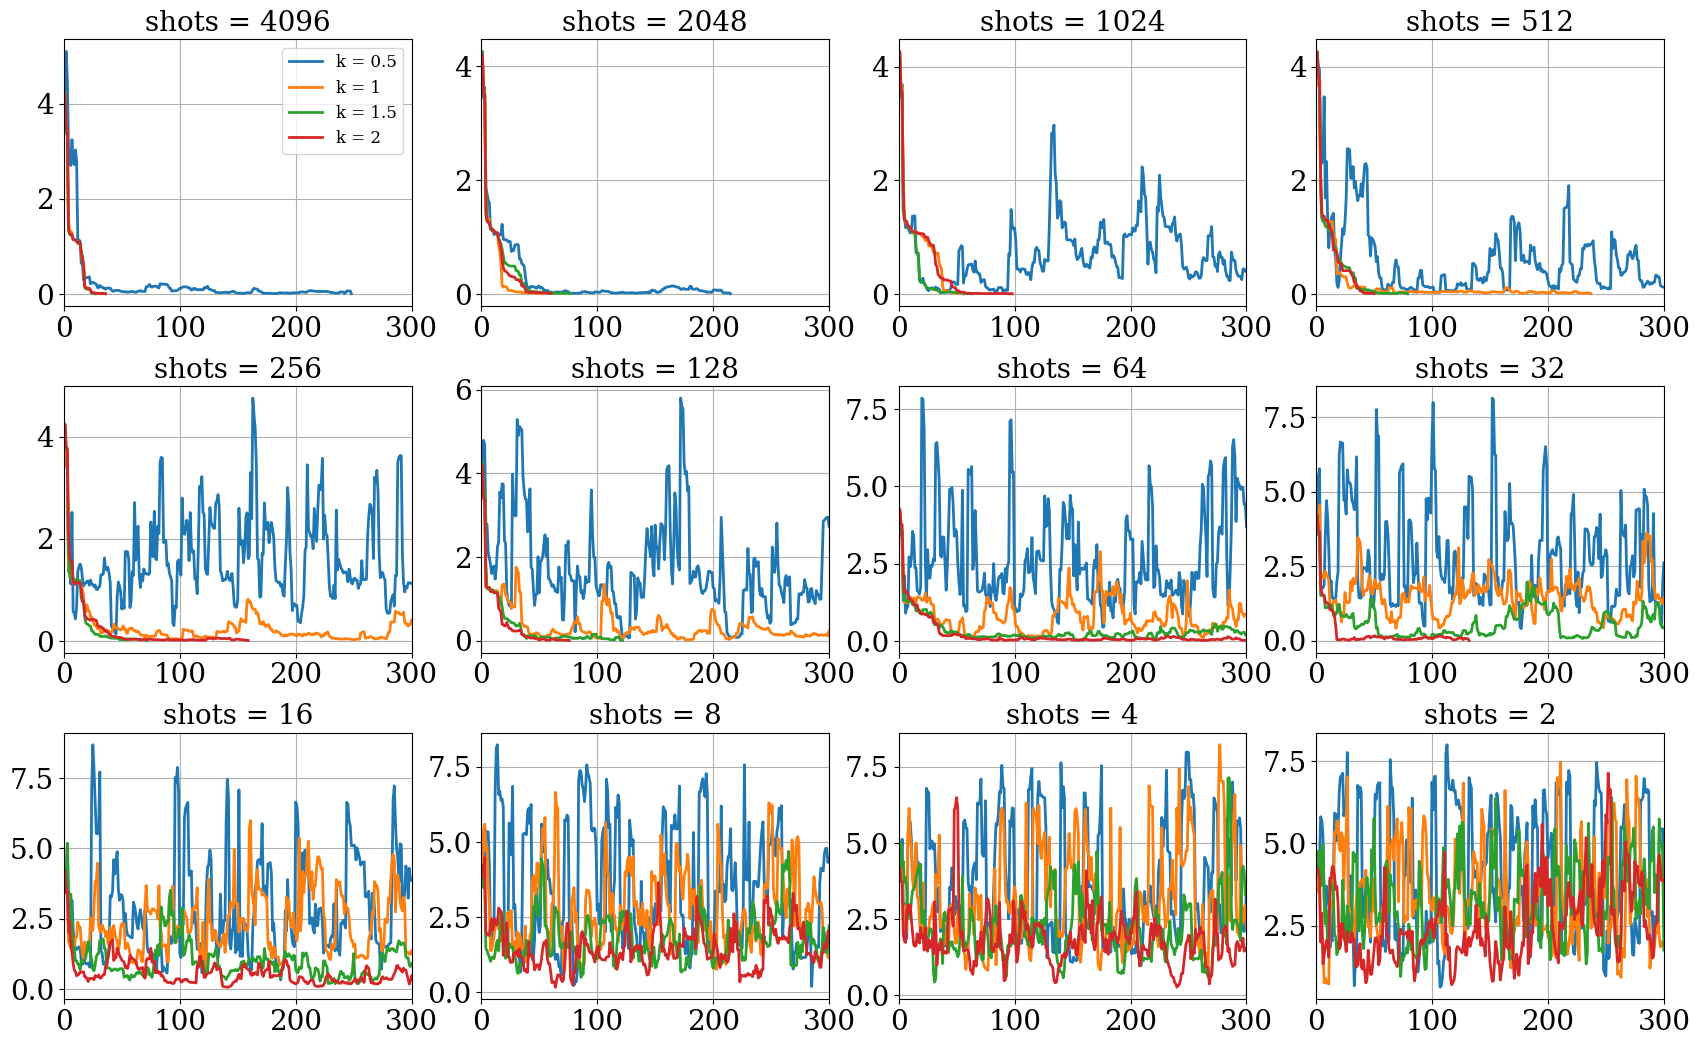

In [135]:
def plot_oicd_results(all_results, k_set, num_iter,
                      rows=3, cols=4,
                      figsize=(20, 12),
                      colors=None,    # 新增 colors 参数
                      save_path=None):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    # 如果没传 colors，就用默认循环色
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for idx, result in enumerate(all_results):
        ax = axes[idx]
        n_shot = result['n_shot']
        metrics = result['metrics']

        for i, values in enumerate(metrics):
            label = f'k = {k_set[i]}'
            if k_set[i] == 0.5:
                color = colors[0]  # 指定颜色
            elif k_set[i] == 1:
                color = colors[1]
            elif k_set[i] == 1.5:
                color = colors[2]
            elif k_set[i] == 2:
                color = colors[3]
            ax.plot(values, label=label, linewidth=2, color=color)

        ax.set_title(f"shots = {n_shot}")
        ax.set_xlim(0, num_iter)
        ax.grid(True)
        if idx == 0:
            ax.legend(fontsize=12, loc='upper right')

    plt.subplots_adjust(
        left=0.1, right=0.9,
        bottom=0.1, top=0.9,
        wspace=0.2, hspace=0.3
    )

    if save_path:
        plt.savefig(save_path)
    plt.show()

# 调用时，给 k_set = [0.5, 1, 1.5, 2] 指定你想要的颜色列表：
my_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']  # 红、蓝、绿、紫

plot_oicd_results(
    all_results_1, k_set_1, num_iter=300,
    rows=3, cols=4,
    save_path="maxcut_oicd_all_nshot_subplots_1.png"
)


## focus on k=1.5, 2

In [136]:
num_iter = 500
k_set_2 = [1.5, 2]
# shot_list = [2**n for n in reversed(range(1, 13))] # from 4096 to 2
shot_list_2 = [shot for shot in range(64,32,-4)] # from 4096 to 2

In [137]:

# Step 1: 生成数据
all_results_2, interp_configs, MSE_values = run_oicd_all_shots(
    num_p, ground_energy, initial_weights, omegas,
    num_iter, k_set_2, shot_list_2, tol
)



===== Running for n_shot = 64 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 218, 18(20), Metric: 0.0090, Elapsed: 0.02s:  44%|████▎     | 218/500 [00:04<00:06, 44.80it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 499, 19(20), Metric: 0.0405, Elapsed: 0.02s: 100%|██████████| 500/500 [00:11<00:00, 44.68it/s]



===== Running for n_shot = 60 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 499, 19(20), Metric: 0.1051, Elapsed: 0.02s: 100%|██████████| 500/500 [00:11<00:00, 45.28it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 499, 19(20), Metric: 0.0723, Elapsed: 0.02s: 100%|██████████| 500/500 [00:11<00:00, 44.26it/s]



===== Running for n_shot = 56 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 499, 19(20), Metric: 0.0730, Elapsed: 0.02s: 100%|██████████| 500/500 [00:11<00:00, 45.24it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 499, 19(20), Metric: 0.0831, Elapsed: 0.02s: 100%|██████████| 500/500 [00:11<00:00, 44.77it/s]



===== Running for n_shot = 52 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 499, 19(20), Metric: 0.0924, Elapsed: 0.02s: 100%|██████████| 500/500 [00:10<00:00, 45.52it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 74, 14(20), Metric: 0.0064, Elapsed: 0.02s:  15%|█▍        | 74/500 [00:01<00:09, 44.53it/s]



===== Running for n_shot = 48 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 499, 19(20), Metric: 0.2393, Elapsed: 0.02s: 100%|██████████| 500/500 [00:11<00:00, 43.57it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 499, 19(20), Metric: 0.0826, Elapsed: 0.02s: 100%|██████████| 500/500 [00:11<00:00, 42.32it/s]



===== Running for n_shot = 44 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 499, 19(20), Metric: 0.1184, Elapsed: 0.02s: 100%|██████████| 500/500 [00:11<00:00, 44.41it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 499, 19(20), Metric: 0.2060, Elapsed: 0.02s: 100%|██████████| 500/500 [00:11<00:00, 44.09it/s]



===== Running for n_shot = 40 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 499, 19(20), Metric: 0.6631, Elapsed: 0.02s: 100%|██████████| 500/500 [00:11<00:00, 44.66it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 499, 19(20), Metric: 0.1871, Elapsed: 0.03s: 100%|██████████| 500/500 [00:11<00:00, 43.46it/s]



===== Running for n_shot = 36 =====
----------------------------------------------------------------------------------------------------


[OICD] Iter: 499, 19(20), Metric: 1.0502, Elapsed: 0.02s: 100%|██████████| 500/500 [00:11<00:00, 44.91it/s]


----------------------------------------------------------------------------------------------------


[OICD] Iter: 499, 19(20), Metric: 0.1041, Elapsed: 0.02s: 100%|██████████| 500/500 [00:11<00:00, 43.93it/s]


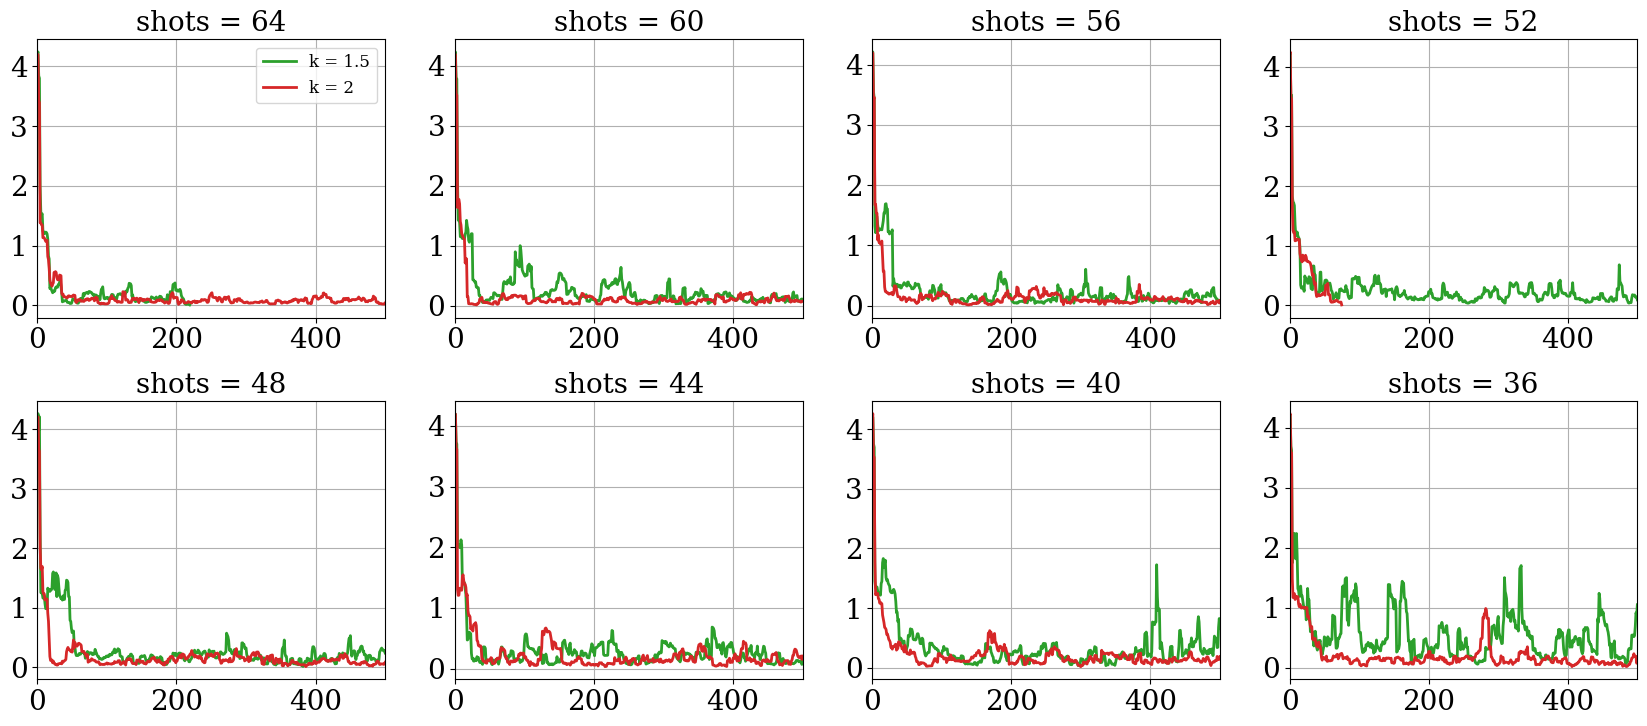

In [138]:
# Step 2: 画图（可反复修改样式）
plot_oicd_results(
    all_results_2, k_set_2, num_iter,
    rows=2, cols=4,
    figsize=(20, 12*(2/3)),
    save_path="maxcut_oicd_all_nshot_subplots_2.png"
)

# Performance Metrics as a Function of Scaling Factor k

In [139]:

# Given omega values
omegas = [1]

# Interpolation matrix function
def interp_matrix(interp_nodes, omegas):
    r = len(omegas)
    # Build the interpolation matrix
    return np.array([[1/np.sqrt(2)] + [func(omegas[k] * x) for k in range(r) for func in (np.cos, np.sin)] for x in interp_nodes])

# Mean Squared Error (MSE) function
def mse(interp_nodes, omegas):
    # Create interpolation matrix
    A = interp_matrix(interp_nodes, omegas)
    
    # Regularize the matrix (small regularization term to avoid singular matrices)
    regularized_matrix = A.T @ A + 1e-6 * np.eye(A.shape[1])  
    
    # Return the trace of the inverse of the regularized matrix
    return np.trace(np.linalg.inv(regularized_matrix))

# Condition Number function
def cond(interp_nodes, omegas):
    # Compute the condition number of the interpolation matrix
    return np.linalg.cond(interp_matrix(interp_nodes, omegas))

# Average Variance of Derivatives function (h(x))
def h(interp_nodes, omegas, order=1):
    r = len(omegas)

    # Weight diagonal for the variance matrix
    def weight_daigonal(r, order=1):
        diag_elements = [0]  # Start with 0
        for i in range(1, r + 1):
            diag_elements.extend([i**(2 * order), i**(2 * order)])  # Diagonal elements based on order
        return 0.5 * np.diag(diag_elements)

    A = interp_matrix(interp_nodes, omegas)
    regularization = 1e-8 * np.eye(A.shape[1])  # Small regularization term
    VAR = np.linalg.inv(A.T @ A + regularization)
    
    I_d = weight_daigonal(r, order)

    return np.sum(VAR * I_d)

# Initialize lists to store values
mse_values = []
cond_values = []
h_values = []

# Range of k values
# k_values = np.linspace(0.1, 2.9, 100)  # k varies from 0.1 to 2.9 (avoiding k=0)
k_values = np.linspace(0.1, 2.9, 100)  # k varies from 0.1 to 2.9 (avoiding k=0)

r = 2*len(omegas)+1  # Number of interpolation nodes

# Loop to compute MSE, Condition Number, and h for each k
for k in k_values:
    interp_nodes = np.linspace(0, k * np.pi, r, endpoint=False)
    mse_values.append(mse(interp_nodes, omegas))
    cond_values.append(cond(interp_nodes, omegas))
    h_values.append(h(interp_nodes, omegas, order=1))


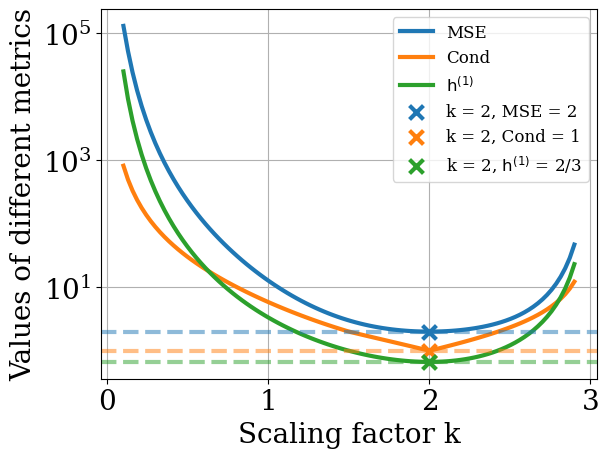

In [140]:

plt.figure()

# Plotting the results with customized colors
plt.plot(k_values, mse_values, 
         label="MSE", color=colors[0]) #  (Mean Squared Error)
plt.plot(k_values, cond_values, 
         label="Cond", color=colors[1]) # (Condition Number)
plt.plot(k_values, h_values, 
         label=r"$\mathrm{h}^{(1)}$", color=colors[2]) # (Average Variance of Derivatives)

# Labels and title
plt.xlabel("Scaling factor k")
plt.ylabel("Values of different metrics")
plt.yscale('log')  # Set y-axis to logarithmic scale
# plt.title("Performance Metrics as a Function of Scaling Factor k")
plt.grid(True)

# Adding horizontal lines for reference
plt.axhline(y=2, color=colors[0], linestyle='--', alpha=0.5)
plt.axhline(y=1, color=colors[1], linestyle='--', alpha=0.5)
plt.axhline(y=2/3, color=colors[2], linestyle='--', alpha=0.5)

# Highlight the point at k = 2
k_target = 2
interp_nodes_target = np.linspace(0, k_target * np.pi, 2 * len(omegas) + 1, endpoint=False)

mse_target = mse(interp_nodes_target, omegas)
cond_target = cond(interp_nodes_target, omegas)
h_target = h(interp_nodes_target, omegas, order=1)

# Mark the point on the plot (k = 2, MSE value)
plt.scatter(k_target, mse_target, 
            color=colors[0], marker='x', s=100, zorder=5, 
            label=f'k = {k_target}, MSE = {mse_target:.0f}')
plt.scatter(k_target, cond_target, 
            color=colors[1], marker='x', s=100, zorder=5, 
            label=f'k = {k_target}, Cond = {cond_target:.0f}')
plt.scatter(k_target, h_target, 
            color=colors[2], marker='x', s=100, zorder=5, 
            label = fr'k = {k_target}, $\mathrm{{h}}^{{(1)}}$ = 2/3'
            )

# Display legend
plt.legend()

plt.savefig('metrics_with_diff_iterp_nodes.png', bbox_inches='tight')

# Show the plot
plt.show()
